In [19]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
from collections import Counter
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold
from IPython import get_ipython
import time

%matplotlib notebook


def nextplot():
    inNotebook = "IPKernelApp" in get_ipython().config
    if inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()  # and this clears the current one

# Load the data

In [20]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [21]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [22]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

<IPython.core.display.Javascript object>


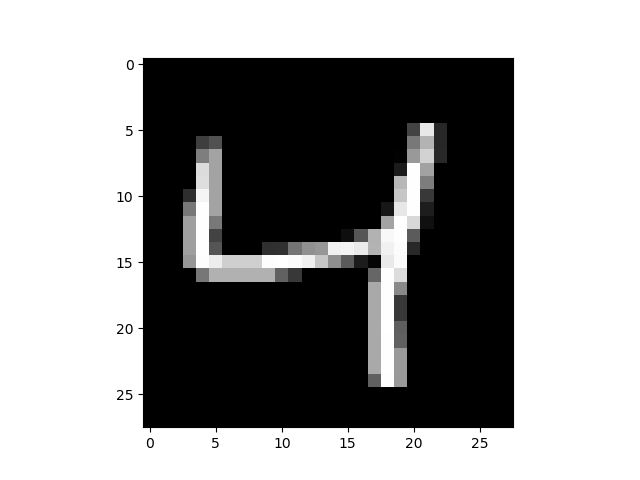

4


In [23]:
# Example: show first digit
nextplot()
showdigit(X[2,])
print(y[2])

In [24]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(Counter(y).values()))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

<IPython.core.display.Javascript object>


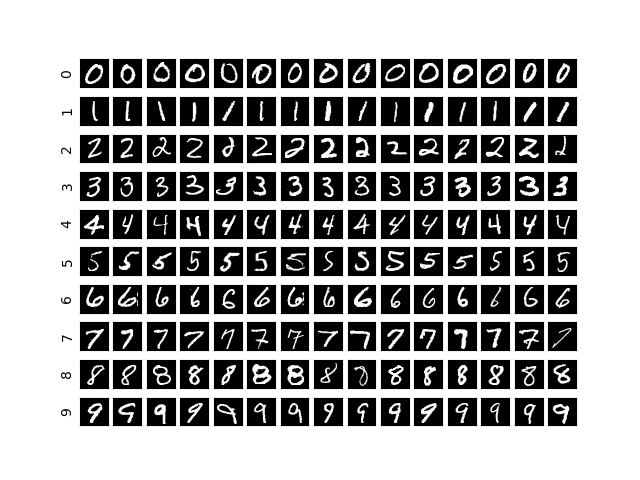

In [25]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

<IPython.core.display.Javascript object>


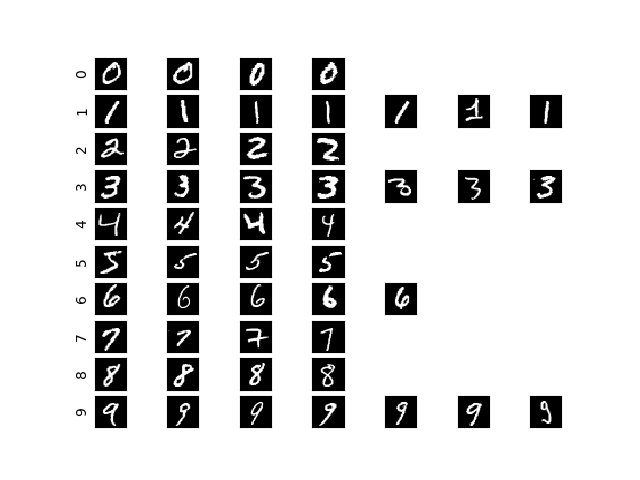

In [26]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [1]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

NameError: name 'np' is not defined

In [28]:
print(Xex)
print(yex)

[[1 0]
 [0 1]
 [1 1]
 [2 0]]
[0 1 2 0]


# 1 Training

In [33]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = np.zeros(C)
    alpha_c = alpha * C
    for nc in range(C):
        n = np.sum(y == nc)
        priors[nc] = (n + alpha - 1) / (N + alpha_c - C)
    
    # Get p(class)
    # YOUR CODE HERE

    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K)) + alpha - 1
    # Get p(x|class)
    # YOUR CODE HERE
    
    '''
    for nc in range(C):
        for nd in range(D):
            for nk in range(K):
                n = np.sum((X[:,nd] == nk) & (y == nc))
                cls[nc, nd, nk] = ( n + alpha - 1 )
            cls[nc, nd] = cls[nc, nd] / np.sum(cls[nc, nd])
    '''
    
    for nc in range(C):
        for nd in range(D):
            n = np.unique(X[:,nd][(y==nc)], return_counts=True)
            cls[nc,nd,n[0]] += n[1]
            cls[nc,nd,:] = (cls[nc,nd,:])/np.sum(cls[nc,nd])
    
    #print(cls)

    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [34]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model

# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [35]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  ## here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [36]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [37]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    
    '''
    for n_new in range(Nnew):
        for nc in range(C):
            # logcls_c = logcls[nc]
            validjoint1 = 0
            for nd in range(D):
                validjoint = logcls[nc, nd, Xnew[n_new, nd]]
                validjoint1 += validjoint
            logjoint[n_new, nc] = np.sum([(validjoint1, logpriors[nc])])
    '''
    
    for nc in range(C):
        validjoint1 = np.zeros(Nnew)
        validjoint = np.zeros(Nnew)
        for nd in range(D):
            validjoint[:] = logcls[nc, nd, Xnew[:, nd]]
            validjoint1[:] += validjoint[:]
        logjoint[:, nc] = np.sum([(validjoint1[:], logpriors[nc])])
        
    # print(logjoint)
    # YOUR CODE HERE

    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")
    # YOUR CODE HERE  

    yhat = np.zeros(Nnew,dtype=int)
    logprob = np.zeros(Nnew)
    logproball = np.zeros((Nnew, C))    
    
    '''
    for n_new in range(Nnew):
        for nc in range(C):
            if np.exp(logjoint[n_new, nc]) > 0:
               # logproball[n_new, nc] = np.log(np.exp(logjoint[n_new, nc])) - logsumexp(logjoint[n_new])
                logproball[n_new, nc] = np.log(np.exp(logjoint[n_new, nc] - logsumexp(logjoint[n_new])))
            else:
                logproball[n_new, nc] = -np.inf
        logprob[n_new] = np.amax(logproball[n_new])
        yhat[n_new] = np.argmax(logproball[n_new])


    
    for row in range(Nnew):
        sumprob = logsumexp(logjoint[row])
        for clas in range(C):
            prob = np.exp(logjoint[row, clas]- sumprob)
            if(prob > 0):
                logproball[row, clas] = np.log(prob)
            else:
                logproball[row, clas] = -np.inf
        yhat[row] = np.argmax(logproball[row])
        logprob[row] = logproball[row, yhat[row]]
    '''
    
    sumprob = np.zeros(Nnew)
    sumprob[:] = [logsumexp(logjoint[row]) for row in range(Nnew)]
    #print(sumprob)
    
    for nc in range(C):
        prob = np.exp(logjoint[:, nc] - sumprob[:])
        logproball[:, nc] = np.where(prob > 0, np.log(prob), -np.inf)
        
    yhat[:] = [np.argmax(logproball[row]) for row in range(Nnew)]
    logprob[:] = [logproball[row, yhat[row]] for row in range(Nnew)] 
        
    #print(yhat)
    
    return dict(yhat=yhat, logprob=logprob)

In [38]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
predt = nb_predict(model, Xex)
predt
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

# 3 Experiments on MNIST Digits Data

In [41]:
# Let's train the model on the digits data and predict
start = time.time()
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]
print('Time taken {} seconds'.format(time.time() - start))

Time taken 3.4567553997039795 seconds


/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


In [42]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

<IPython.core.display.Javascript object>


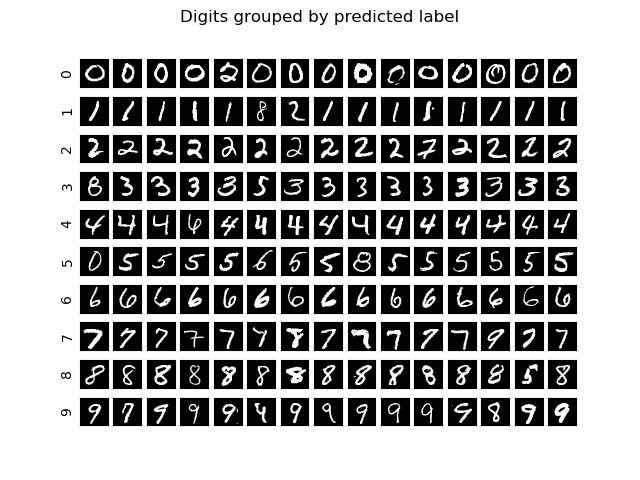

Text(0.5,0.98,'Digits grouped by predicted label')

In [43]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")
#plt.savefig('3_digits_predicted.png')

<IPython.core.display.Javascript object>


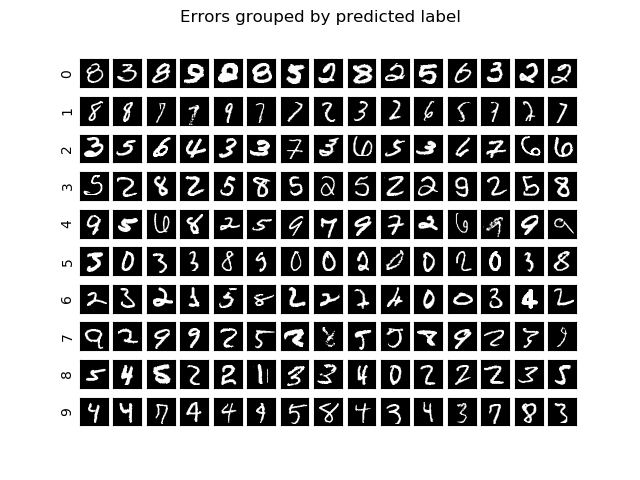

In [44]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")
#plt.savefig('3_errors_predicted.png')

<IPython.core.display.Javascript object>


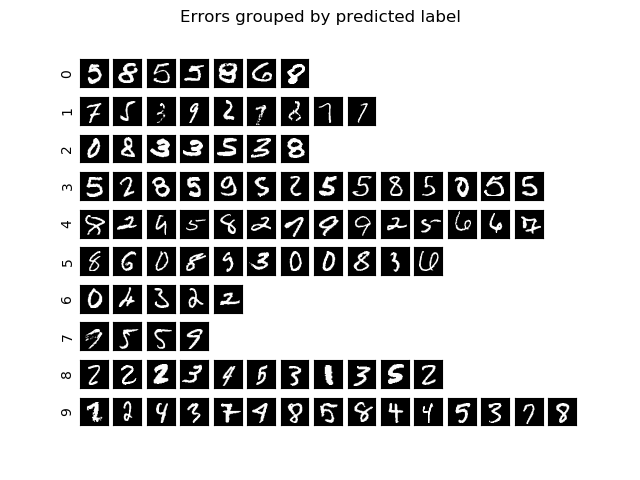

In [45]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")
#plt.savefig('3_errors_proportion.png')

In [46]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

<IPython.core.display.Javascript object>


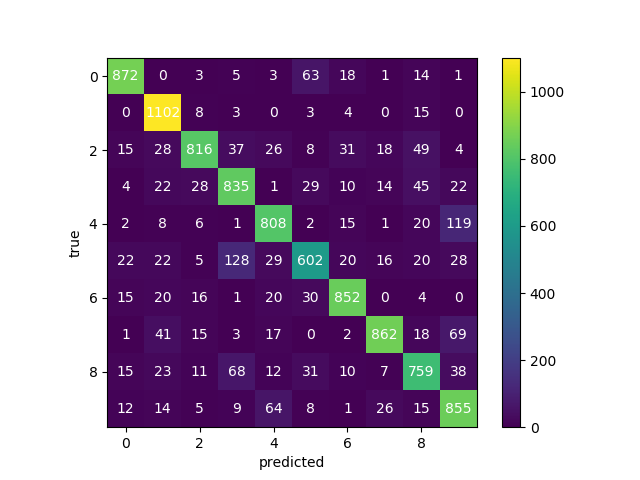

In [47]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()
#plt.savefig('3_conf_mat.png')

<IPython.core.display.Javascript object>


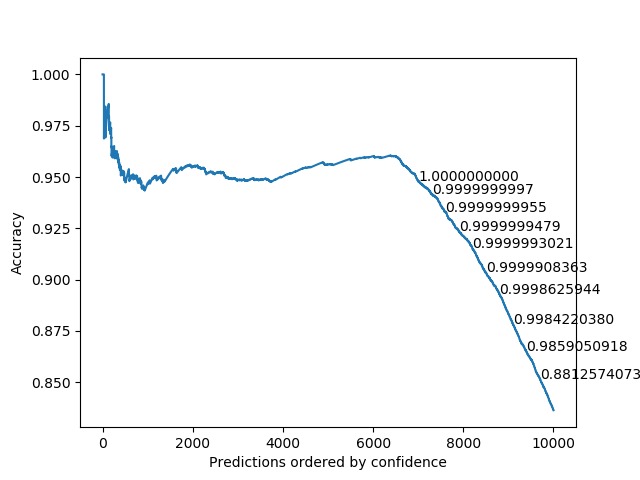

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937705
0.9859050917808865
0.8812574072791101


In [48]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

<IPython.core.display.Javascript object>


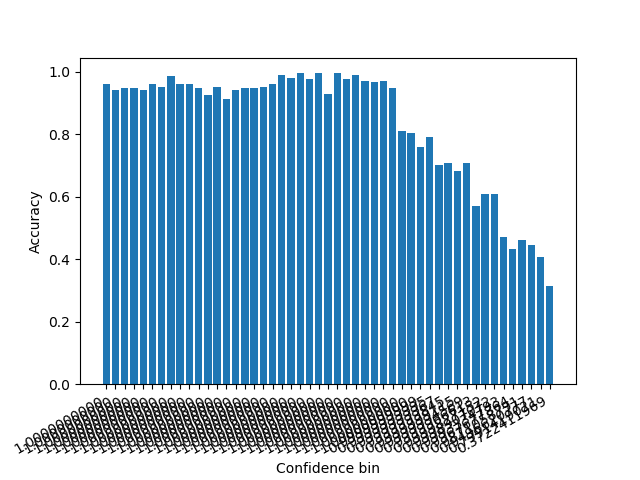

Text(0,0.5,'Accuracy')

In [49]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [50]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points


In [51]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
# YOUR CODE HERE
N=50
K=5
Kf = KFold(n_splits=K, shuffle=True)
acc = np.zeros([N,K])
accuracy = np.zeros(N)

alp=1
for alpha in np.linspace(1.0, 5.0, num=N):
    fold = 1
    for i_train, i_test in Kf.split(X):
        model_nb_cv = nb_train(X[i_train], y[i_train], alpha)
        pred_nb_cv = nb_predict(model_nb_cv, X[i_test])
        y_hat = pred_nb_cv["yhat"]
        log_prob = pred_nb_cv["logprob"]

        acc[alp-1, fold-1] = sklearn.metrics.accuracy_score(y[i_test], y_hat)
        fold = fold+1
    accuracy[alp-1] = np.average(acc[alp-1])
    alp = alp+1
    


/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log
/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in greater
/Users/soumya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log


In [53]:
accuracy

array([0.30311667, 0.83556667, 0.83516667, 0.83435   , 0.83308333,
       0.83271667, 0.83165   , 0.83071667, 0.8303    , 0.82923333,
       0.82853333, 0.8271    , 0.82723333, 0.82633333, 0.82451667,
       0.82391667, 0.82308333, 0.82108333, 0.82011667, 0.81925   ,
       0.81823333, 0.81681667, 0.81641667, 0.81551667, 0.81455   ,
       0.81326667, 0.81258333, 0.8114    , 0.80988333, 0.80921667,
       0.8082    , 0.80685   , 0.8061    , 0.80448333, 0.80385   ,
       0.80295   , 0.80118333, 0.80056667, 0.79871667, 0.79785   ,
       0.79661667, 0.79583333, 0.79473333, 0.79393333, 0.79313333,
       0.79178333, 0.79041667, 0.79045   , 0.78883333, 0.78755   ])

<IPython.core.display.Javascript object>


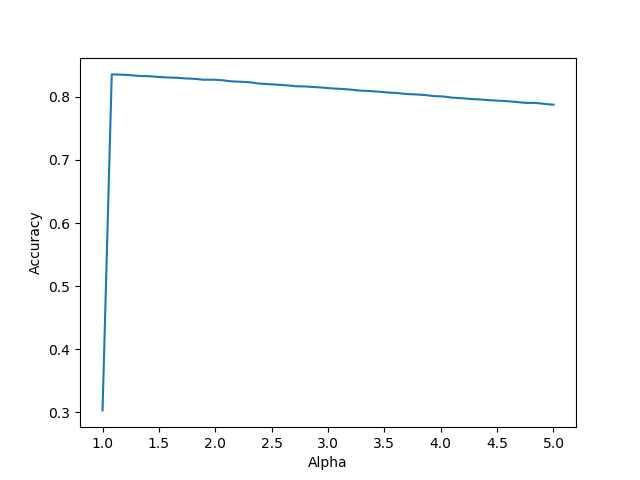

In [54]:
nextplot()
plt.plot(np.linspace(1.0, 5.0, num=N), accuracy)
#plt.gcf().autofmt_xdate()

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
#plt.savefig('4_alpha_acc.png')

# 5 Generating Data

In [56]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        # YOUR CODE HERE
        for nd in range(D):
            theta = np.exp(logcls[c, nd])
            Xgen[i, nd] = np.random.choice(range(K),p=theta)

    return Xgen

<IPython.core.display.Javascript object>


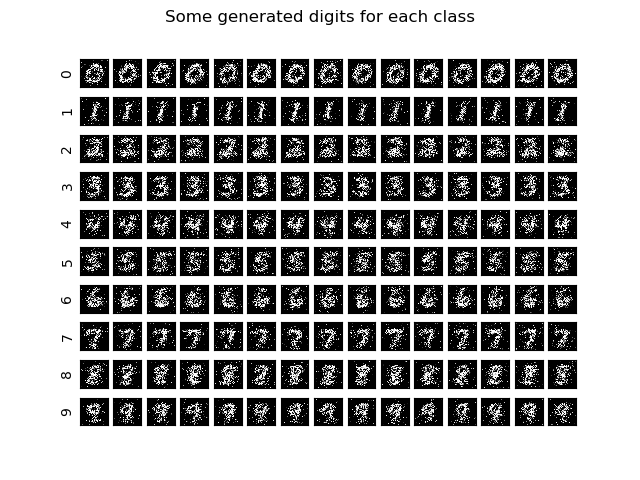

Text(0.5,0.98,'Some generated digits for each class')

In [57]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")
#plt.savefig('5_gen_data.png')

<IPython.core.display.Javascript object>


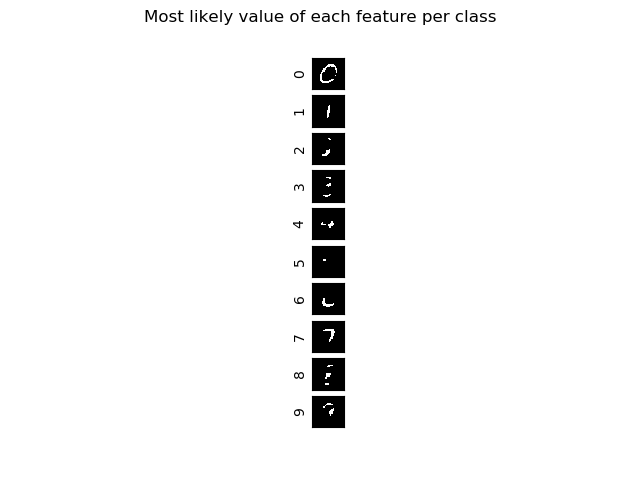

Text(0.5,0.98,'Most likely value of each feature per class')

In [58]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")
#plt.savefig('5_most_like.png')

<IPython.core.display.Javascript object>


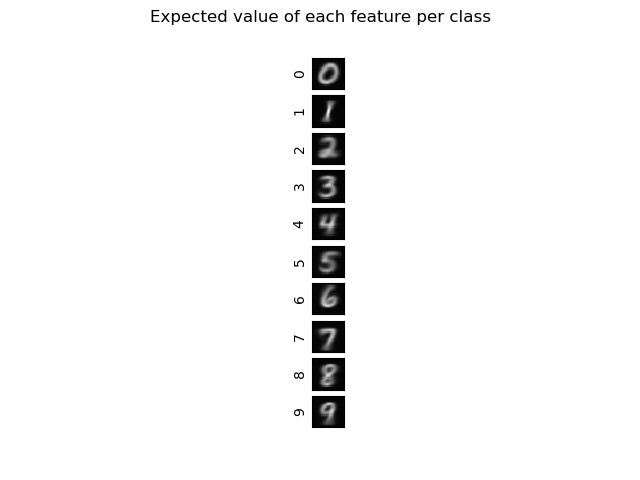

Text(0.5,0.98,'Expected value of each feature per class')

In [59]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")
#plt.savefig('5_expected.png')

<IPython.core.display.Javascript object>


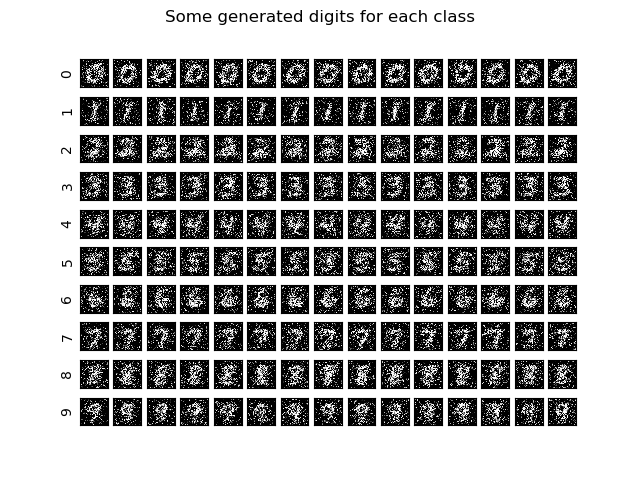

In [61]:
model_nb3 = nb_train(X, y, alpha=6)
Xgen3 = nb_generate(model_nb3, ygen)

nextplot()
showdigits(Xgen3, ygen)
plt.suptitle("Some generated digits for each class")
plt.savefig('5_gen2.png')

<IPython.core.display.Javascript object>


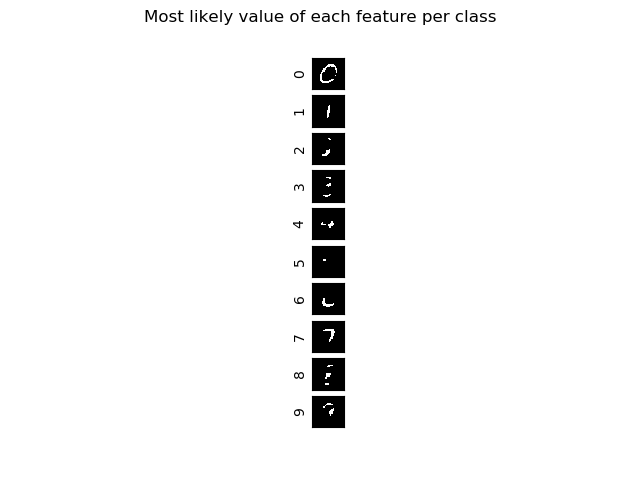

Text(0.5,0.98,'Most likely value of each feature per class')

In [62]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb3["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

<IPython.core.display.Javascript object>


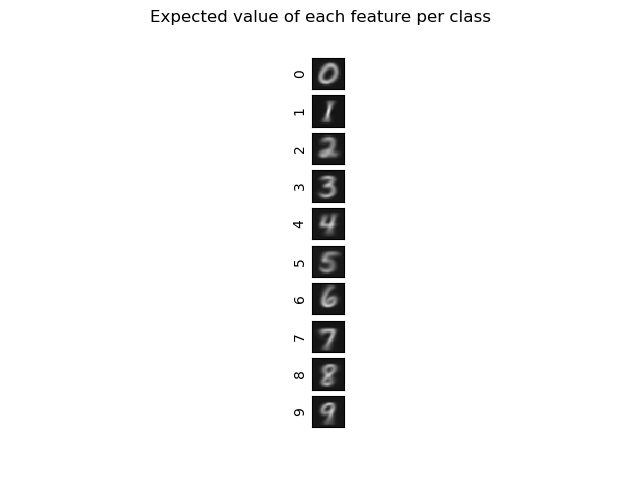

Text(0.5,0.98,'Expected value of each feature per class')

In [63]:
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb3["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")